In [1]:
import pathlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
! ls data/

strong_fft_n=128000000_p=64_11077776 weak_fft_n=512000000_p=64_11077796
strong_fft_n=128000000_p=64_11077778 weak_fft_n=512000000_p=64_11077797
strong_fft_n=128000000_p=64_11079322 weak_fft_n=512000000_p=64_11077800
weak_fft_n=4096000000_p=512_11079232


In [3]:
df0 = pd.read_csv('data/weak_fft_n=4096000000_p=512_11079232/weak_fft_n=4096000000_p=512_11079232.csv')
df1 = pd.read_csv('data/weak_fft_n=512000000_p=64_11077800/weak_fft_n=512000000_p=64_11077800.csv')
df2 = pd.read_csv('data/weak_fft_n=512000000_p=64_11077796/weak_fft_n=512000000_p=64_11077796.csv')


In [4]:
import seaborn as sns

def weak_scaling(dfs, names=None, title="Weak Scaling Performance"):
    """
    Plots weak scaling results (runtime + efficiency) for one or more DataFrames.

    Parameters
    ----------
    dfs : list of pandas.DataFrame or pandas.DataFrame
        One or more DataFrames with columns including:
        ['experiment_id', 'runtime', 'p2m', 'm2l', 'm2m', 'l2l', 'source_tree', 'n_points', 'source_local_trees_per_rank']
    names : list of str, optional
        Names/labels for each DataFrame. Must be same length as dfs.
    title : str
        Figure title.
    """

    # Handle single DataFrame
    if not isinstance(dfs, (list, tuple)):
        dfs = [dfs]
    if names is None:
        names = [f"Run {i+1}" for i in range(len(dfs))]

    sns.set_context("talk", font_scale=1.1)
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    ax_runtime, ax_eff = axes

    markers = ['o', 's', '^', 'D', 'v', 'P', '*']
    colors = sns.color_palette("deep", len(dfs))

    for df, label, color, marker in zip(dfs, names, colors, markers):
        # Aggregate per experiment
        stats = df.groupby('experiment_id')[['runtime', 'p2m', 'm2l', 'm2m', 'l2l',
                                             'source_tree', 'n_points', 'source_local_trees_per_rank']]
        runtime = stats.mean()['runtime']
        runtime_err = stats.std()['runtime']
        n_ranks = stats.size()
        n_points = stats.mean()['n_points'] * n_ranks  # total DoFs = per-rank * ranks

        # Reference runtime (lowest rank)
        T_ref = runtime.iloc[0]
        efficiency = (T_ref / runtime) * 100

        # Runtime plot
        ax_runtime.errorbar(
            n_points, runtime, yerr=runtime_err,
            fmt=marker+'-', color=color, capsize=4, label=label,
            linewidth=2, markersize=7
        )

        # Efficiency plot
        ax_eff.plot(
            n_ranks, efficiency, marker=marker, linestyle='-', color=color,
            label=label, linewidth=2, markersize=7
        )

    # --- Runtime plot formatting ---
    ax_runtime.set_xscale('log')
    ax_runtime.set_yscale('log')
    ax_runtime.set_xlabel('Total Number of Points (DoFs)', fontsize=13)
    ax_runtime.set_ylabel('Runtime (ms)', fontsize=13)
    ax_runtime.set_title('Weak Scaling (Runtime)', fontsize=14)
    ax_runtime.grid(True, which="both", ls="--", lw=0.5)
    ax_runtime.legend(fontsize=11)

    # --- Efficiency plot formatting ---
    ax_eff.set_xscale('log', base=2)
    ax_eff.set_ylim(0, 110)
    ax_eff.set_xlabel('Number of Ranks', fontsize=13)
    ax_eff.set_ylabel('Parallel Efficiency (%)', fontsize=13)
    ax_eff.set_title('Parallel Efficiency', fontsize=14)
    ax_eff.grid(True, which="both", ls="--", lw=0.5)
    ax_eff.legend(fontsize=11)

    # --- Global figure adjustments ---
    fig.suptitle(title, fontsize=16, y=1.03)
    plt.tight_layout()
    plt.show()


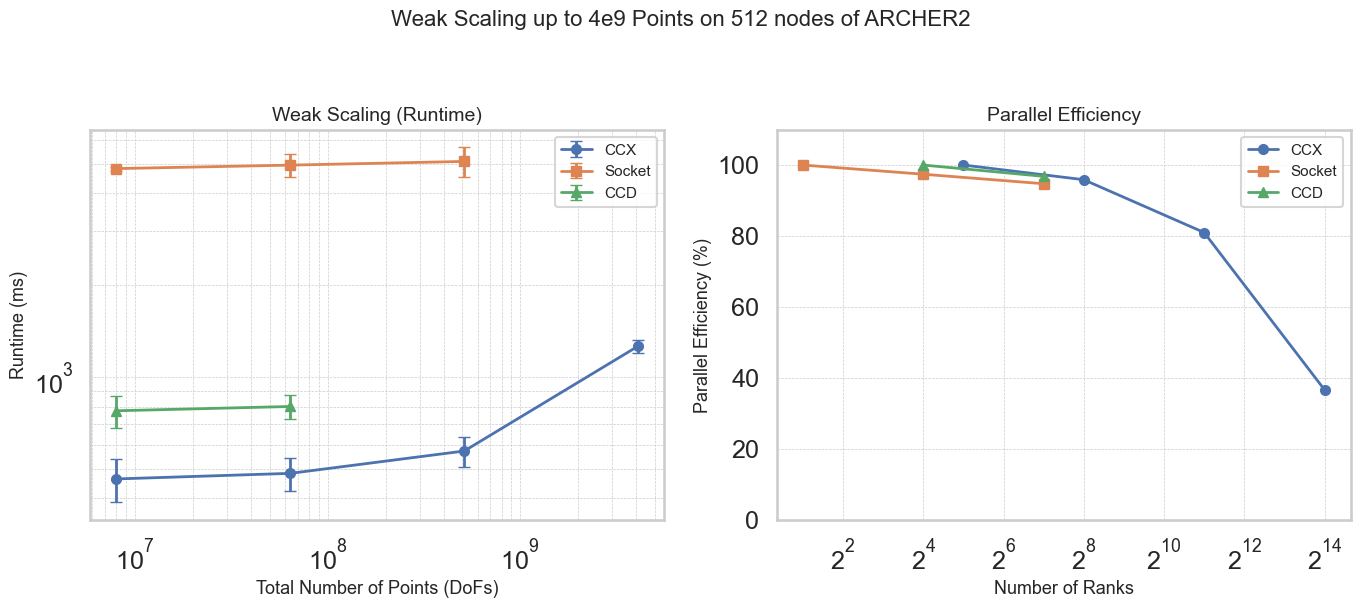

In [19]:
weak_scaling([df0, df1, df2], names=["CCX", "Socket", "CCD"], title="Weak Scaling up to 4e9 Points on 512 nodes of ARCHER2")